# Day 08. Exercise 02
# Multiclass classification. One-hot encoding. Random forest

## 0. Imports

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score

## 1. Preprocessing

1. Read the file [`checker-submits.csv`](https://drive.google.com/file/d/14voc4fNJZiLEFaZyd8nEG-lQt5JjatYw/view?usp=sharing).
2. Create a dataframe `df` with the columns: `uid`, `labname`, `numTrials`, `hour`, `dayofweek` where `hour` is extracted from the `timestamp` as well as the `dayofweek` (`0` is Monday, `6` is Sunday). We will try to predict the day of the week having data about which user made a commit for which lab at which hour and which try it was.
3. Using `OneHotEncoder()` transform your categorical features, delete from the dataframe the initial columns.
4. Use `StandardScaler()` and scale your continuous features.
5. Save the dataframe as `dayofweek.csv`.
6. Before trying out different algorithms, find out the accuracy of the naive algorithms – the one that predicts everything as the most popular class.

1. Прочитайте файл [`checker-submits.csv`](https://drive.google.com/file/d/14voc4fNJZiLEFaZyd8nEG-lQt5JjatYw/view?usp=sharing).
2. Создайте фрейм данных `df` со столбцами: `uid`, `labname`, `numTrials`, `hour`, `dayofweek`, где `hour` извлекается из `timestamp`, а также `dayofweek` (`0` — понедельник, `6` — воскресенье). Мы попытаемся предсказать день недели, имея данные о том, какой пользователь сделал коммит для какой лаборатории, в какой час и какая попытка это была.
3. Используя `OneHotEncoder()` преобразуйте ваши категориальные признаки, удалите из фрейма данных начальные столбцы.
4. Используйте `StandardScaler()` и масштабируйте ваши непрерывные признаки.
5. Сохраните фрейм данных как `dayofweek.csv`.
6. Прежде чем пробовать разные алгоритмы, выясните точность наивных алгоритмов — тех, которые предсказывают все как самый популярный класс.

In [50]:
df = pd.read_csv('../data/checker_submits.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [51]:
df.shape

(1686, 4)

In [52]:
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek 

In [53]:
df = df[['uid', 'labname', 'numTrials', 'hour', 'dayofweek']]
df.shape

(1686, 5)

In [54]:
X = df.drop('dayofweek', axis=1)
y = df['dayofweek']

In [55]:
cat_cols = ['uid', 'labname']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_encoded = encoder.fit_transform(X[cat_cols])

In [56]:
cat_features = encoder.get_feature_names_out(cat_cols)

In [57]:
cont_cols = ['numTrials', 'hour']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[cont_cols])

In [58]:
X_processed = np.hstack([X_encoded, X_scaled])
feature_names = np.concatenate([cat_features, cont_cols])

In [59]:
processed_df = pd.DataFrame(X_processed, columns=feature_names)
processed_df['dayofweek'] = y

In [60]:
processed_df.to_csv('../data/dayofweek.csv', index=False)
processed_df.shape

(1686, 44)

In [61]:
most_common_class = y.mode()[0]
naive_accuracy = accuracy_score(y, [most_common_class] * len(y))
print(f"Naive Classifier Accuracy: {naive_accuracy:.4f}")

Naive Classifier Accuracy: 0.2349


In [62]:
def plot_feature_importance(coefs, feature_names, top_n=10, mode="max"):
    """
    - mode: 
        "sum"   — Σ |coef_k|  (sum across classes)
        "max"   — max |coef_k| (most extreme influence)
        "sumsq" — Σ coef_k²    (squared influence)
    """
    if len(coefs.shape) > 1:
        if mode == "sum":
            importance = np.sum(np.abs(coefs), axis=0)
        elif mode == "max":
            importance = np.max(np.abs(coefs), axis=0)
        elif mode == "sumsq":
            importance = np.sum(coefs**2, axis=0)
        else:
            raise ValueError("mode must be 'sum', 'max', or 'sumsq'")
    else:
        importance = np.abs(coefs) if mode != "sumsq" else coefs**2

    # Get top features
    sorted_idx = np.argsort(importance)[-top_n:][::-1]
    top_features = [feature_names[i] for i in sorted_idx]
    top_importance = importance[sorted_idx]

    # Plot
    plt.figure(figsize=(8, 0.45 * top_n + 2))
    plt.barh(range(top_n), top_importance)
    plt.yticks(range(top_n), top_features)
    plt.gca().invert_yaxis()
    plt.xlabel("Importance")
    plt.title(f"Top-{top_n} Features ({mode} mode)")
    plt.tight_layout()
    plt.show()


## 2. Algorithms

### a. Logreg

1. Train logistic regression, for the baseline model use `random_state=21`, `fit_intercept=False`. 
2. Calculate the accuracy.
3. Write a function that draws the plot (`barh`) taking coefficients of any trained models, names of the features and the number of `top-n` most important features to display.
4. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model.
5. Remember that it is a multiclass classification and `coef_` returns a matrix, to calculate importance for a feature you need to sum all the individual feature importances for all the target values.

1. Обучите логистическую регрессию, для базовой модели используйте `random_state=21`, `fit_intercept=False`.
2. Рассчитайте точность.
3. Напишите функцию, которая рисует график (`barh`), принимая коэффициенты любых обученных моделей, названия признаков и количество `top-n` самых важных признаков для отображения.
4. Нарисуйте график (`barh`) для базовой модели с топ-10 самых важных признаков (абсолютное значение) для обученной модели.
5. Помните, что это многоклассовая классификация, а `coef_` возвращает матрицу, чтобы рассчитать важность признака, вам нужно просуммировать все отдельные значения важности признаков для всех целевых значений.

Logistic Regression Accuracy: 0.6406


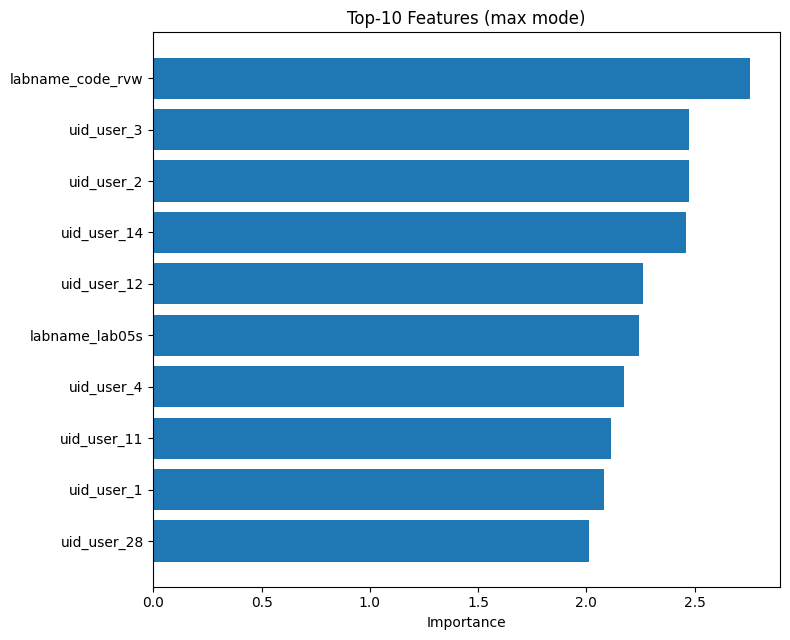

In [63]:
logreg = LogisticRegression(random_state=21, fit_intercept=False, max_iter=1000)
logreg.fit(X_processed, y)

# Calculate accuracy
y_pred_logreg = logreg.predict(X_processed)
logreg_accuracy = accuracy_score(y, y_pred_logreg)
print(f"Logistic Regression Accuracy: {logreg_accuracy:.4f}")

plot_feature_importance(logreg.coef_, feature_names, top_n=10)

### b. SVC

1. Train a `SVC` model, for the baseline model use parameters `kernel='linear'`, `probability=True`, `random_state=21`. 
2. Try different kernels, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model for the linear kernel *

*By default SVC uses “one vs one” strategy of the classification, thus in `coef_` it returns a matrix. To calculate importance for a feature you need to use [OneVsRestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) over the SVC and sum all the individual feature importances for all the target values.

1. Обучите модель `SVC`, для базовой модели используйте параметры `kernel='linear'`, `probability=True`, `random_state=21`.
2. Попробуйте разные ядра, рассчитайте точность.
3. Нарисуйте график (`barh`) для базовой модели с 10 наиболее важными признаками (абсолютное значение) для обученной модели для линейного ядра *

*По умолчанию SVC использует стратегию классификации «один против одного», поэтому в `coef_` он возвращает матрицу. Чтобы вычислить важность признака, вам нужно использовать [OneVsRestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) для SVC и просуммировать все отдельные значения важности признаков для всех целевых значений.

SVC (linear kernel) Accuracy: 0.7028
SVC (poly kernel) Accuracy: 0.8594
SVC (rbf kernel) Accuracy: 0.8559
SVC (sigmoid kernel) Accuracy: 0.3998

Feature importance for SVC with linear kernel (One-vs-Rest):


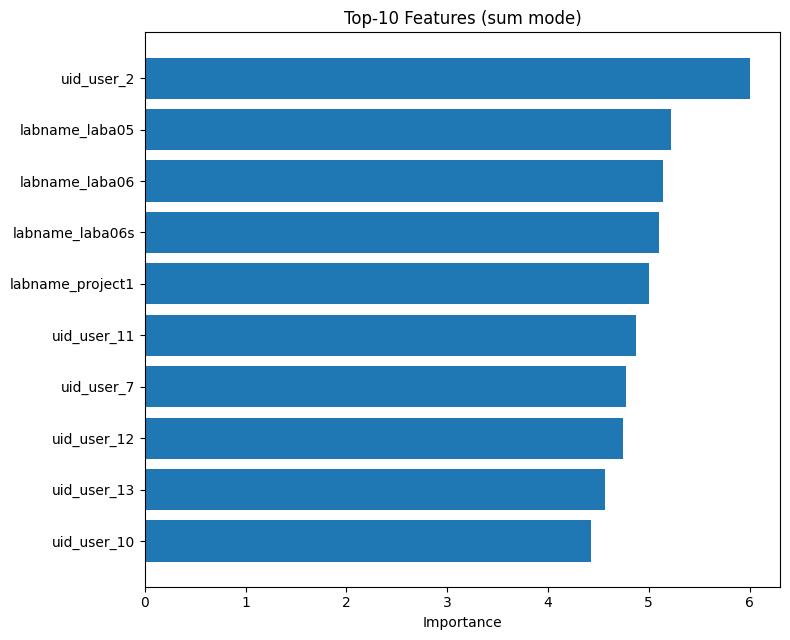

In [64]:
# Try different kernels
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
best_svc_accuracy = 0
best_svc_kernel = None

for kernel in kernels:
    svc = SVC(kernel=kernel, probability=True, random_state=21)
    svc.fit(X_processed, y)
    y_pred_svc = svc.predict(X_processed)
    acc = accuracy_score(y, y_pred_svc)
    print(f"SVC ({kernel} kernel) Accuracy: {acc:.4f}")
    
    if acc > best_svc_accuracy:
        best_svc_accuracy = acc
        best_svc_kernel = kernel
        best_svc = svc  
print("\nFeature importance for SVC with linear kernel (One-vs-Rest):")
ovr_svc = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=21))
ovr_svc.fit(X_processed, y)

coefs = np.array([clf.coef_[0] for clf in ovr_svc.estimators_])

plot_feature_importance(coefs, feature_names, top_n=10, mode='sum')

In [65]:
# For linear kernel
if best_svc_kernel == 'linear':
    ovr_svc = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=21))
    ovr_svc.fit(X_processed, y)
    coefs = np.array([clf.coef_[0] for clf in ovr_svc.estimators_])
    plot_feature_importance(coefs, feature_names, top_n=10)

In [66]:
print(X.dtypes)

uid          object
labname      object
numTrials     int64
hour          int32
dtype: object


### c. Decision tree

1. Train a `DecisionTreeClassifier` using for the baseline model `max_depth=4`, `random_state=21`. 
2. Try different values of `max_depth`, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model using the written function.

1. Обучите `DecisionTreeClassifier`, используя для базовой модели `max_depth=4`, `random_state=21`.
2. Попробуйте разные значения `max_depth`, рассчитайте точность.
3. Нарисуйте график (`barh`) для базовой модели с 10 наиболее важными признаками (абсолютное значение) для обученной модели, используя написанную функцию.

Decision Tree (max_depth=4) Accuracy: 0.5516
Decision Tree (max_depth=8) Accuracy: 0.5516
Decision Tree (max_depth=12) Accuracy: 0.5516
Decision Tree (max_depth=16) Accuracy: 0.5516
Decision Tree (max_depth=20) Accuracy: 0.5516


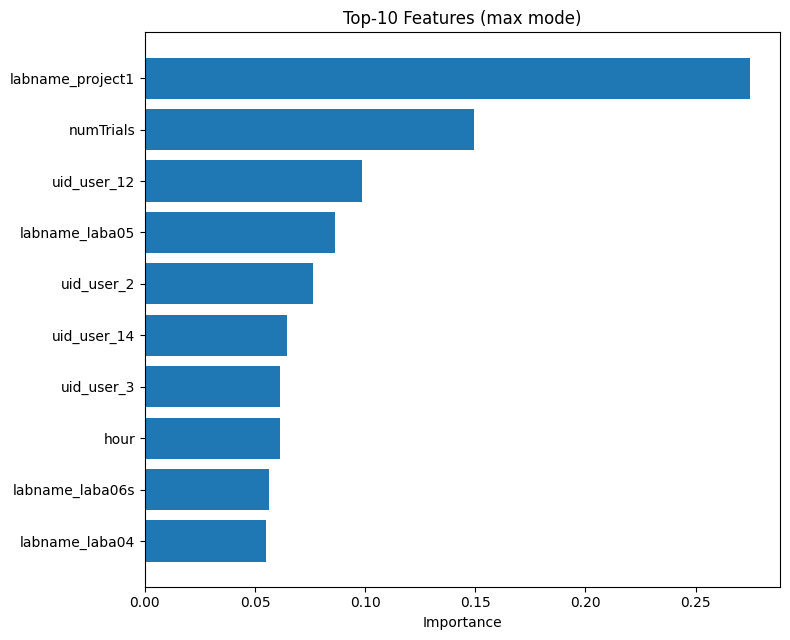

In [67]:
# Try different depths
depths = [4, 8, 12, 16, 20]
best_tree_accuracy = 0

for depth in depths:
    tree = DecisionTreeClassifier(max_depth=4, random_state=21)
    tree.fit(X_processed, y)
    y_pred_tree = tree.predict(X_processed)
    acc = accuracy_score(y, y_pred_tree)
    print(f"Decision Tree (max_depth={depth}) Accuracy: {acc:.4f}")
    if acc > best_tree_accuracy:
        best_tree_accuracy = acc
        best_tree = tree

plot_feature_importance(best_tree.feature_importances_, feature_names, top_n=10)


### d. Random forest

In real life forest is a set of trees. The same thing is with machine learning. Random forest is a set of individual decision trees (check the documentation for more details).

1. Train a `RandomForestClassifier` using for the baseline model parameters `n_estimators=100`, `max_depth = 25`, `random_state=21`. 
2. Try different values of `max_depth` and `n_estimators`, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model using the written function.

В реальной жизни лес — это набор деревьев. То же самое и с машинным обучением. Случайный лес — это набор отдельных деревьев решений (подробнее см. в документации).

1. Обучите `RandomForestClassifier`, используя для параметров базовой модели `n_estimators=100`, `max_depth = 25`, `random_state=21`.
2. Попробуйте разные значения `max_depth` и `n_estimators`, рассчитайте точность.
3. Нарисуйте график (`barh`) для базовой модели с 10 наиболее важными признаками (абсолютное значение) для обученной модели, используя написанную функцию.

Random Forest (n_est=50, max_depth=15) Accuracy: 0.9810
Random Forest (n_est=50, max_depth=25) Accuracy: 0.9994
Random Forest (n_est=50, max_depth=35) Accuracy: 1.0000
Random Forest (n_est=100, max_depth=15) Accuracy: 0.9804
Random Forest (n_est=100, max_depth=25) Accuracy: 0.9994
Random Forest (n_est=100, max_depth=35) Accuracy: 1.0000
Random Forest (n_est=150, max_depth=15) Accuracy: 0.9816
Random Forest (n_est=150, max_depth=25) Accuracy: 0.9994
Random Forest (n_est=150, max_depth=35) Accuracy: 1.0000


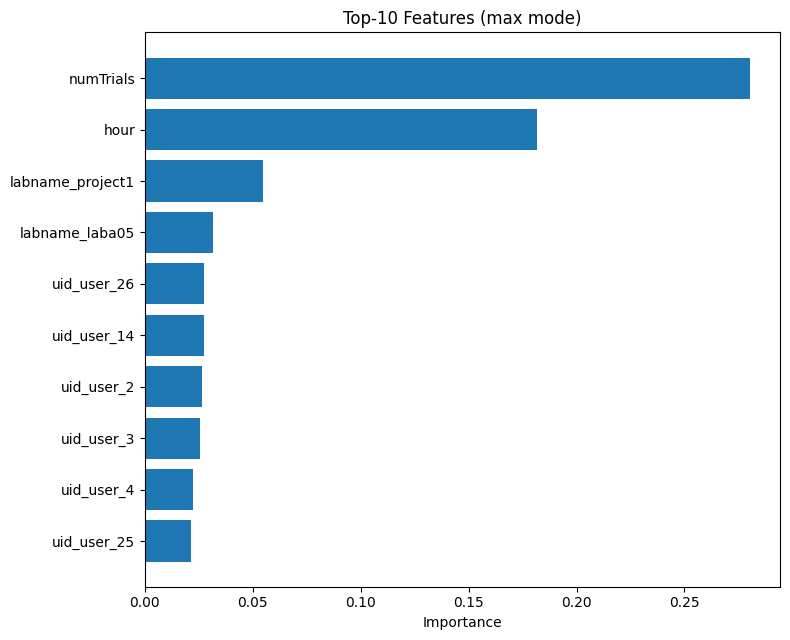

In [68]:
# Try different parameters
n_estimators_list = [50, 100, 150]
max_depths = [15, 25, 35]
best_rf_accuracy = 0

for n_est in n_estimators_list:
    for depth in max_depths:
        rf = RandomForestClassifier(n_estimators=n_est, max_depth=depth, random_state=21)
        rf.fit(X_processed, y)
        y_pred_rf = rf.predict(X_processed)
        acc = accuracy_score(y, y_pred_rf)
        print(f"Random Forest (n_est={n_est}, max_depth={depth}) Accuracy: {acc:.4f}")
        
        if acc > best_rf_accuracy:
            best_rf_accuracy = acc
            best_rf = rf

plot_feature_importance(best_rf.feature_importances_, feature_names, top_n=10)